# Mask segmentation using Unet

In [209]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from PIL import Image


In [103]:
data_path = '../MSFD/1/face_crop/'
ans_path = '../MSFD/1/face_crop_segmentation/'

data_list = []
ans_list = []

for fname in os.listdir(data_path):
    data_list.append(fname) 


for fname in os.listdir(ans_path):
    ans_list.append(fname) 

print(len(data_list),len(ans_list),data_list[1],ans_list[1])

9383 9383 002267_2.jpg 002267_2.jpg


In [198]:
def check_and_delete(image_path, mask_path):
    """Opens image and mask; deletes both if either is None."""
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if image is None or mask is None:
        print(f"Deleting corrupt files: {image_path} and {mask_path}")
        os.remove(image_path) if os.path.exists(image_path) else print(f"File not found: {image_path}")
        os.remove(mask_path) if os.path.exists(mask_path) else print(f"File not found: {mask_path}")

for file in data_list:
    image_path = os.path.join(data_path, file)
    mask_path = os.path.join(ans_path, file)
    check_and_delete(image_path, mask_path)

Deleting corrupt files: ../MSFD/1/face_crop/000601_1.jpg and ../MSFD/1/face_crop_segmentation/000601_1.jpg
File not found: ../MSFD/1/face_crop_segmentation/000601_1.jpg


[ WARN:0@123033.680] global loadsave.cpp:268 findDecoder imread_('../MSFD/1/face_crop_segmentation/000601_1.jpg'): can't open/read file: check file path/integrity


In [104]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)



In [105]:
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p

In [106]:
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], 1)
        return self.conv(x)

### Data loader definition

All images were scaled to 72x72 resolution

In [135]:
IMG_SIZE = 72

class MaskDataset(Dataset):
    def __init__(self, image_folder, mask_folder):
        super(MaskDataset, self).__init__()
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.image_filenames = os.listdir(image_folder)
        self.transform = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_folder, self.image_filenames[idx])

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            print(f"Warning: Failed to load {img_path} or {mask_path}")
            return None 
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        image = self.transform(image)

        mask = Image.fromarray(mask)
        mask = self.transform(mask)
        mask = (mask > 0.5).float()  # Convert to binary mask

        return image, mask



_Train test split_

In [139]:

# Load dataset
full_dataset = MaskDataset(image_folder=data_path, mask_folder=ans_path)
train_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

print(f"Train Size: {train_size}, Test Size: {test_size}")



Train Size: 1876, Test Size: 7507


### Unet model

This model consists of 2 pairs of layers (2 up, 2 down), plus a bottleneck layer. Parameters were chosen to improve performance for the model, which is otherwise relatively small. The smaller model allows for improved training times.

Activation fn: Leaky ReLU 

Optimizer: Adam

Scheduler: LR scheduler

In [140]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.LeakyReLU(0.1, inplace=True),
            )

        self.encoder1 = conv_block(in_channels, 32)
        self.pool1 = nn.MaxPool2d(2)  # 128 -> 64

        self.encoder2 = conv_block(32, 64)
        self.pool2 = nn.MaxPool2d(2)  # 64 -> 32

        self.bottleneck = conv_block(64, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # 32 -> 64
        self.decoder1 = conv_block(128, 64)

        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)  # 64 -> 128
        self.decoder2 = conv_block(64, 32)

        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        x = self.pool1(enc1)

        enc2 = self.encoder2(x)
        x = self.pool2(enc2)

        x = self.bottleneck(x)

        x = self.upconv1(x)
        x = torch.cat([x, enc2], dim=1)
        x = self.decoder1(x)

        x = self.upconv2(x)
        x = torch.cat([x, enc1], dim=1)
        x = self.decoder2(x)

        return torch.sigmoid(self.final_conv(x))


# Create model instance
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
print(model)


UNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1,

In [141]:
LEARNING_RATE = 3e-4
BATCH_SIZE = 8

model = UNet(in_channels=3).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)



## Running the Unet model

In [142]:
def dice_coefficient(prediction, target, epsilon=1e-07):
    prediction_copy = prediction.clone()

    prediction_copy[prediction_copy < 0] = 0
    prediction_copy[prediction_copy > 0] = 1

    intersection = abs(torch.sum(prediction_copy * target))
    union = abs(torch.sum(prediction_copy) + torch.sum(target))
    dice = (2. * intersection + epsilon) / (union + epsilon)
    
    return dice

def iou_score(prediction, target, epsilon=1e-07):
    prediction_copy = prediction.clone()

    prediction_copy[prediction_copy < 0] = 0
    prediction_copy[prediction_copy > 0] = 1

    intersection = torch.sum(prediction_copy * target)
    union = torch.sum(prediction_copy) + torch.sum(target) - intersection

    iou = (intersection + epsilon) / (union + epsilon)

    return iou


In [143]:
x = np.array([1, 2, 3])
y = torch.from_numpy(x)

_Training the model_

In [144]:
num_epochs = 10

model.to(device)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_iou = 0
    epoch_dice = 0

    # Training loop
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        if images is None or masks is None:
            continue

        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Compute IoU & Dice
        iou = iou_score(outputs, masks)
        dice = dice_coefficient(outputs, masks)
        epoch_iou += iou.item()
        epoch_dice += dice.item()

    # Reduce learning rate based on scheduler
    scheduler.step()

    # Print metrics for the epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}, IoU: {epoch_iou/len(train_loader):.4f}, Dice: {epoch_dice/len(train_loader):.4f}")


Epoch 1/10:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 1/10: 100%|██████████| 118/118 [01:25<00:00,  1.38it/s]


Epoch 1/10, Loss: 0.6986, IoU: 0.3162, Dice: 0.4800


Epoch 2/10: 100%|██████████| 118/118 [01:51<00:00,  1.06it/s]


Epoch 2/10, Loss: 0.6482, IoU: 0.3165, Dice: 0.4805


Epoch 3/10: 100%|██████████| 118/118 [01:38<00:00,  1.20it/s]


Epoch 3/10, Loss: 0.6275, IoU: 0.3169, Dice: 0.4808


Epoch 4/10: 100%|██████████| 118/118 [01:43<00:00,  1.14it/s]


Epoch 4/10, Loss: 0.6148, IoU: 0.3168, Dice: 0.4807


Epoch 5/10: 100%|██████████| 118/118 [01:45<00:00,  1.11it/s]


Epoch 5/10, Loss: 0.6074, IoU: 0.3167, Dice: 0.4808


Epoch 6/10: 100%|██████████| 118/118 [01:46<00:00,  1.11it/s]


Epoch 6/10, Loss: 0.6017, IoU: 0.3162, Dice: 0.4800


Epoch 7/10: 100%|██████████| 118/118 [01:31<00:00,  1.28it/s]


Epoch 7/10, Loss: 0.5990, IoU: 0.3170, Dice: 0.4810


Epoch 8/10: 100%|██████████| 118/118 [01:36<00:00,  1.22it/s]


Epoch 8/10, Loss: 0.5968, IoU: 0.3172, Dice: 0.4811


Epoch 9/10: 100%|██████████| 118/118 [01:35<00:00,  1.24it/s]


Epoch 9/10, Loss: 0.5955, IoU: 0.3164, Dice: 0.4803


Epoch 10/10: 100%|██████████| 118/118 [01:31<00:00,  1.28it/s]

Epoch 10/10, Loss: 0.5940, IoU: 0.3169, Dice: 0.4809


Note: Please ignore the IOU and DICE scores above, these were not being used during training

_Saving the trained UNet mode_

In [145]:
checkpoint = {
    "epoch": num_epochs,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "loss": loss
}
torch.save(checkpoint, "unet_checkpoint.pth")
torch.save(model.state_dict(), "unet_model.pth")

In [185]:
model = UNet(in_channels=3).to(device)
model.load_state_dict(torch.load("unet_model.pth", weights_only=True))
model.eval()

UNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1,

### Testing model performance

_Function plot and return mask from the dataset and predicted mask from model for comparison_

In [ ]:
def predict_and_plot_from_loader(model, images, masks, device, idx = 0, plotIt = False):
    # Get a random batch from test_loader        

    # Get the selected image and mask
    image = images[idx].to(device)  # Move to device
    mask = masks[idx].cpu().numpy().squeeze()  # Convert mask to numpy

    # Get model prediction
    model.eval()
    with torch.no_grad():
        output = model(image.unsqueeze(0))  # Add batch dimension
        predicted_mask = output.squeeze(0).squeeze(0).cpu().numpy()
        predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Threshold to binary

    # Convert tensor image to NumPy (for visualization)
    image_np = image.cpu().numpy().transpose(1, 2, 0)  # Change shape from (C, H, W) to (H, W, C)

    # Plot the image, ground truth mask, and model output

    if(plotIt):
        fig, ax = plt.subplots(1, 3, figsize=(12, 4))

        ax[0].imshow(image_np)
        ax[0].set_title("Input Image")
        ax[0].axis("off")

        ax[1].imshow(mask, cmap="gray")
        ax[1].set_title("Ground Truth Mask")
        ax[1].axis("off")

        ax[2].imshow(predicted_mask, cmap="gray")
        ax[2].set_title("Model Prediction")
        ax[2].axis("off")

        plt.show()

    return mask, predicted_mask

_IOU and DICE functions_

In [192]:
def compute_iou(binary_image1, binary_image2):

    # Ensure binary images are in boolean format (0 or 1)
    mask1 = (binary_image1 > 0).astype(np.uint8)
    mask2 = (binary_image2 > 0).astype(np.uint8)

    # Compute intersection and union
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()

    # Compute IoU (avoid division by zero)
    iou = intersection / union if union != 0 else 0.0
    return iou


def compute_dice(binary_image1, binary_image2):

    # Ensure binary images are in boolean format (0 or 1)
    mask1 = (binary_image1 > 0).astype(np.uint8)
    mask2 = (binary_image2 > 0).astype(np.uint8)

    # Compute intersection and sum of pixels in both masks
    intersection = np.logical_and(mask1, mask2).sum()
    total_pixels = mask1.sum() + mask2.sum()

    # Compute Dice Score (avoid division by zero)
    dice = (2 * intersection) / total_pixels if total_pixels != 0 else 0.0
    return dice


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..1.0].


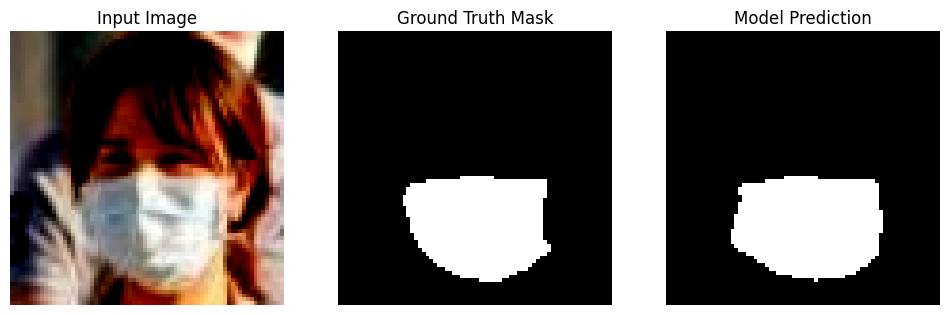

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.9843137].


IOU:0.895361380798274, DICE: 0.9447922595332954


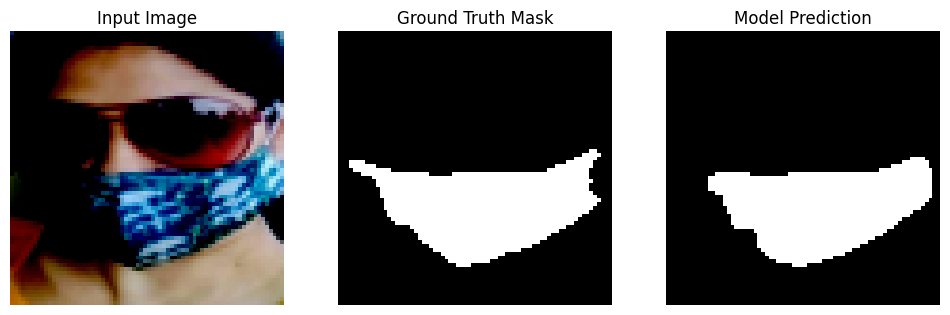

IOU:0.8782837127845884, DICE: 0.9351981351981352


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7019608..1.0].


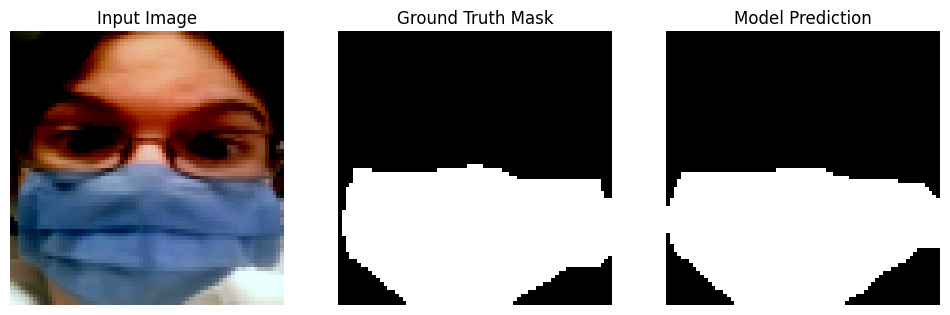

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.99215686].


IOU:0.958904109589041, DICE: 0.9790209790209791


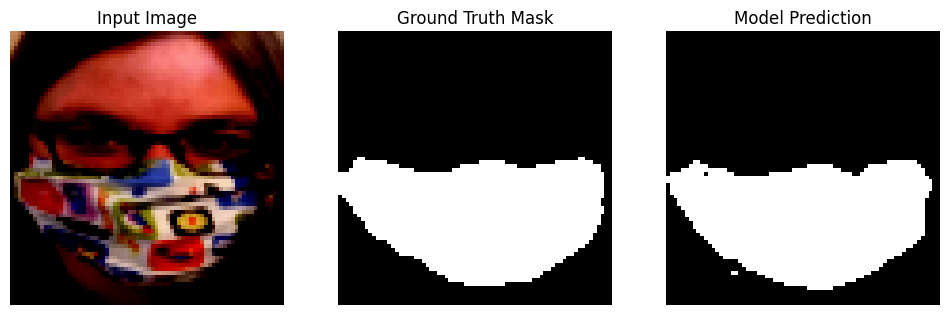

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


IOU:0.9263217097862767, DICE: 0.9617518248175182


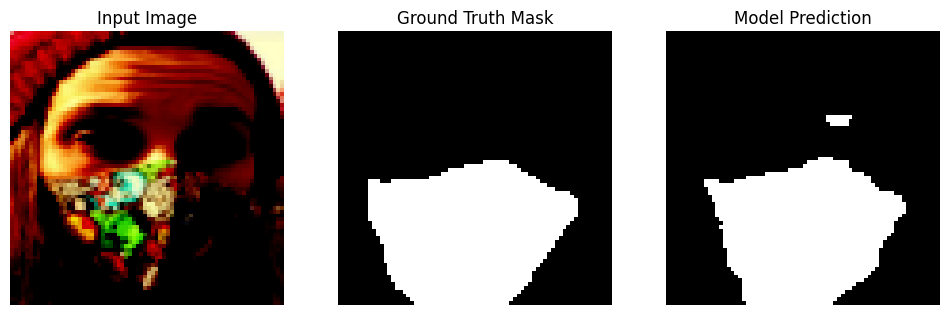

IOU:0.8697819314641745, DICE: 0.9303565478173942


In [194]:
for i in range(5):
    images, masks = next(iter(test_loader))
    idx = random.randint(0, len(images) - 1)
    mask, pred_mask = predict_and_plot_from_loader(model, images, masks, device, idx, True)
    iou, dice = compute_iou(mask, pred_mask), compute_dice(mask, pred_mask)

    print(f"IOU:{iou}, DICE: {dice}")

In [205]:
net_iou, net_dice = 0, 0
ious, dices = [], []
test_iter = iter(test_loader)
while test_iter != None:
    try:
        images, masks = next(test_iter)
        if images == None or masks == None:
            continue
        
        for idx in range(len(images)):
                mask, pred_mask = predict_and_plot_from_loader(model, images, masks, device, idx)
                iou, dice = compute_iou(mask, pred_mask), compute_dice(mask, pred_mask)
                ious.append(iou)
                dices.append(dice)
    except: 
         break


print(f"Average IOU:{np.mean(ious)} | Std dev: {np.std(ious)} ")
print(f"Average DICE: {np.mean(dices)} | Std dev: {np.std(dices)}")


Average IOU:0.8699766295299111 | Std dev: 0.13231294632394658 
Average DICE: 0.9237450613927751 | Std dev: 0.09689654971105476


[ WARN:0@124306.669] global loadsave.cpp:268 findDecoder imread_('../MSFD/1/face_crop/000601_1.jpg'): can't open/read file: check file path/integrity
[ WARN:0@124306.669] global loadsave.cpp:268 findDecoder imread_('../MSFD/1/face_crop_segmentation/000601_1.jpg'): can't open/read file: check file path/integrity


### Conclusion
Average IOU and DICE scores across test set were _0.870_ and _0.923_ respectively. The standard deviation remained quite small at _0.132_ and _0.097_.

A simple UNet model with 5 layers was able to classify identify the mask regions quite accurately, with a good degree of reliability across all images.

This task highlights the effectiveness of UNet model for image segmentation tasks.